C:\Users\21276\AppData\Local\Temp\ipykernel_33860\1583819944.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  customers_df = pd.read_sql(customer_profile_query, conn)
C:\Users\21276\AppData\Local\Temp\ipykernel_33860\1583819944.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  products_df = pd.read_sql(products_query, conn)
C:\Users\21276\AppData\Local\Temp\ipykernel_33860\1583819944.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  fact_df = pd.read_sql(fact_query, conn)
C:\Users\21276\AppData\Local\Temp\ipykerne

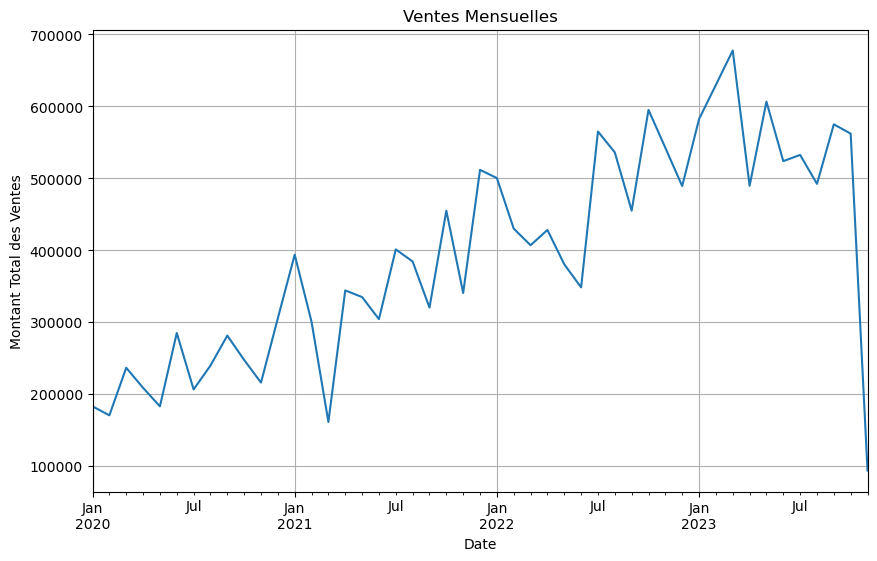

c:\Users\21276\Anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 40498016803.98


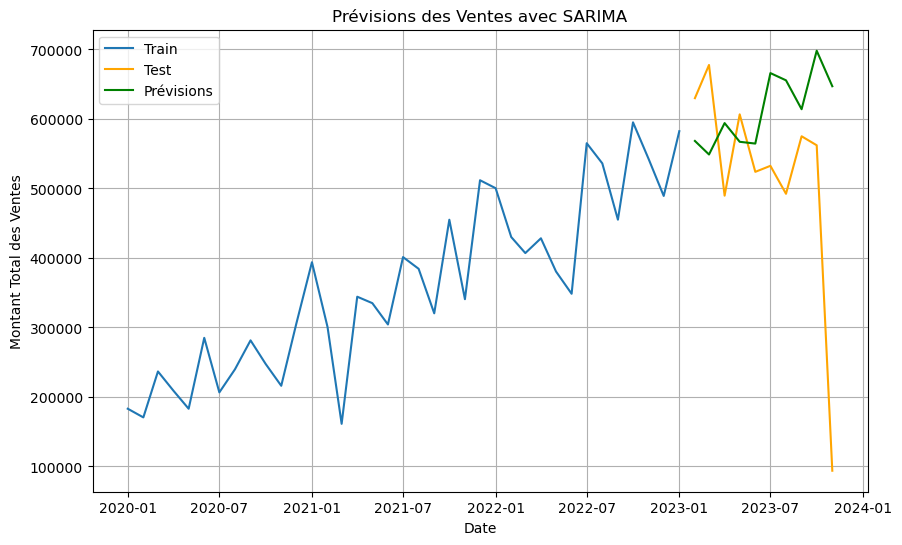

Prévisions des ventes pour les 12 prochains mois :
2023-12-31    568267.511327
2024-01-31    548783.963974
2024-02-29    593952.170464
2024-03-31    567050.101084
2024-04-30    564498.150082
2024-05-31    665913.244533
2024-06-30    655490.795163
2024-07-31    613921.409611
2024-08-31    698087.665630
2024-09-30    646979.293864
2024-10-31    683294.293494
2024-11-30    755269.720673
Freq: M, Name: predicted_mean, dtype: float64


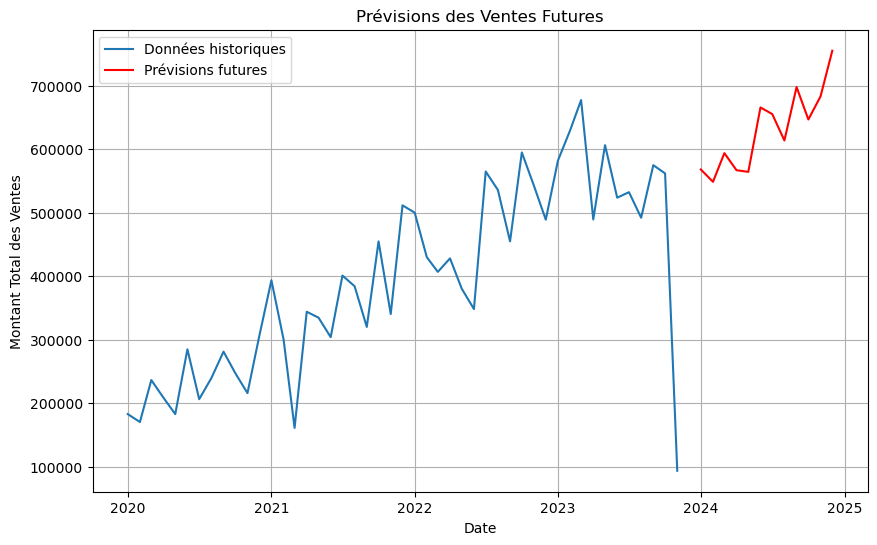

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import pyodbc

# -------------------------------
# Database connection settings
# -------------------------------
server = 'YOUR_SERVER_NAME\\SQLSERVER'  
database = 'your_database_name'          

# Windows Authentication 
conn_str = (
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"Trusted_Connection=yes;"
)

# Connect to SQL Server
conn = pyodbc.connect(conn_str)

# -------------------------------
# Load data from SQL Server
# -------------------------------
customer_profile_query = "SELECT * FROM dim_customer"
products_query = "SELECT * FROM dim_product"
fact_query = "SELECT * FROM fact"
dim_date_query = "SELECT * FROM dim_date"

customers_df = pd.read_sql(customer_profile_query, conn)
products_df = pd.read_sql(products_query, conn)
fact_df = pd.read_sql(fact_query, conn)
dim_date_df = pd.read_sql(dim_date_query, conn)

# -------------------------------
# Data preparation
# -------------------------------
# Add price info and calculate total sales amount
fact_df = fact_df.merge(products_df[['product_id', 'price_per_unit']], on='product_id', how='left')
fact_df['total_amount'] = fact_df['quantity'] * fact_df['price_per_unit']

# Add purchase date from dim_date
fact_df = fact_df.merge(dim_date_df[['date_key', 'date']], on='date_key', how='left')
fact_df.rename(columns={'date': 'purchase_date'}, inplace=True)
fact_df['purchase_date'] = pd.to_datetime(fact_df['purchase_date'])

# Group sales by month
sales_ts = fact_df.groupby(fact_df['purchase_date'].dt.to_period('M'))['total_amount'].sum()
sales_ts = sales_ts.to_timestamp()

# -------------------------------
# Visualization: Historical Sales
# -------------------------------
plt.figure(figsize=(10, 6))
sales_ts.plot(title="Ventes Mensuelles")
plt.xlabel("Date")
plt.ylabel("Montant Total des Ventes")
plt.grid()
plt.show()

# -------------------------------
# SARIMA Forecasting
# -------------------------------
# Split data
train_size = int(len(sales_ts) * 0.8)
train, test = sales_ts[:train_size], sales_ts[train_size:]

# Build and fit the SARIMA model
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# Forecast for test period
forecast = model_fit.forecast(steps=len(test))

# Evaluate model
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error: {mse:.2f}")

# Visualization: Forecast vs Actual
plt.figure(figsize=(10, 6))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color='orange')
plt.plot(forecast, label="Prévisions", color='green')
plt.title("Prévisions des Ventes avec SARIMA")
plt.xlabel("Date")
plt.ylabel("Montant Total des Ventes")
plt.legend()
plt.grid()
plt.show()

# -------------------------------
# Future Forecast (Next 12 months)
# -------------------------------
future_forecast = model_fit.forecast(steps=12)
future_forecast.index = pd.date_range(
    start=sales_ts.index[-1] + pd.offsets.MonthBegin(1),
    periods=12,
    freq='M'
)

print("Prévisions des ventes pour les 12 prochains mois :")
print(future_forecast)

# Visualization: Future Forecast
plt.figure(figsize=(10, 6))
plt.plot(sales_ts, label="Données historiques")
plt.plot(future_forecast, label="Prévisions futures", color='red')
plt.title("Prévisions des Ventes Futures")
plt.xlabel("Date")
plt.ylabel("Montant Total des Ventes")
plt.legend()
plt.grid()
plt.show()
